# Dog + GANS

## Exploratory Data Analysis (EDA)
The dataset used for this project is the Stanford Dogs Dataset, which contains images of various dog breeds. The dataset is processed and visualized to understand its structure and content. Below are some examples of the images in the dataset:


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


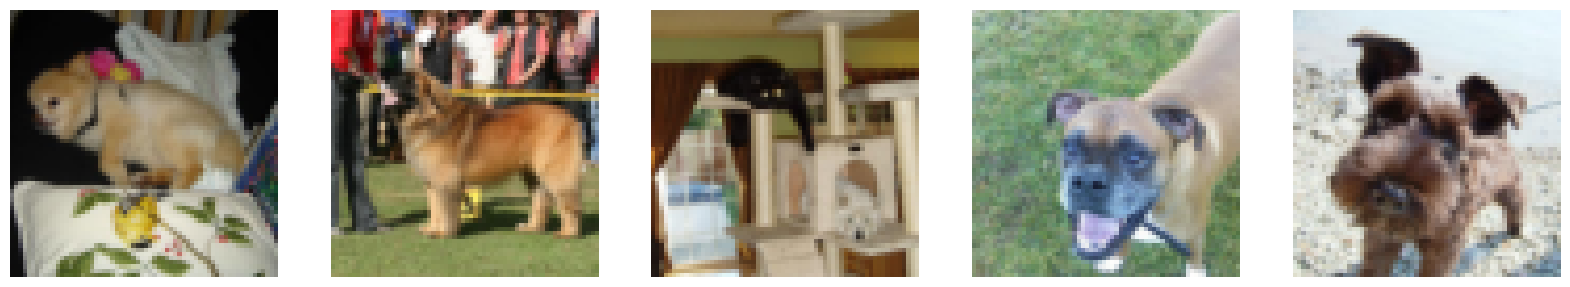

In [28]:
# Unzip the dataset
with zipfile.ZipFile('generative-dog-images/all-dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs_dataset')

# Data transformations and loading
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder('dogs_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualize some images
sample_images, _ = next(iter(dataloader))
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    axes[i].imshow(np.transpose(sample_images[i], (1, 2, 0)) * 0.5 + 0.5)
    axes[i].axis('off')
plt.show()


## Model Architecture
### Generator
The Generator network takes random noise as input and generates realistic images. It consists of several layers of transposed convolutions, batch normalization, and ReLU activations.

### Discriminator
The Discriminator network takes an image as input and outputs a probability indicating whether the image is real or generated. It consists of several layers of convolutions, leaky ReLU activations, and dropout for regularization.

## Training
The GAN is trained using the Adam optimizer with learning rates of 0.001 for the Generator and 0.0005 for the Discriminator. The training process alternates between updating the Discriminator and the Generator.


In [29]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [30]:
# Hyperparameters
batch_size = 64
LR_G = 0.001
LR_D = 0.0005
beta1 = 0.5
epochs = 10
real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

# Fixed noise for generating samples
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

# Training history
G_losses = []
D_losses = []


In [31]:
# Create directory for saving results
os.makedirs('results', exist_ok=True)

for epoch in tqdm(range(epochs), desc="Epochs"):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    if epoch % 1 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for j in range(5):
            axes[j].imshow(np.transpose(fake[j], (1, 2, 0)) * 0.5 + 0.5)
            axes[j].axis('off')
        plt.savefig(f'results/fake_images_epoch_{epoch}.png')
        plt.close()

print("Training completed.")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

[0/10][0/644] Loss_D: 1.4103 Loss_G: 1.9029 D(x): 0.4516 D(G(z)): 0.4495 / 0.1356


Epochs:   0%|          | 0/10 [00:49<?, ?it/s]


KeyboardInterrupt: 

Generating Images: 100%|██████████| 10000/10000 [00:30<00:00, 327.62it/s]


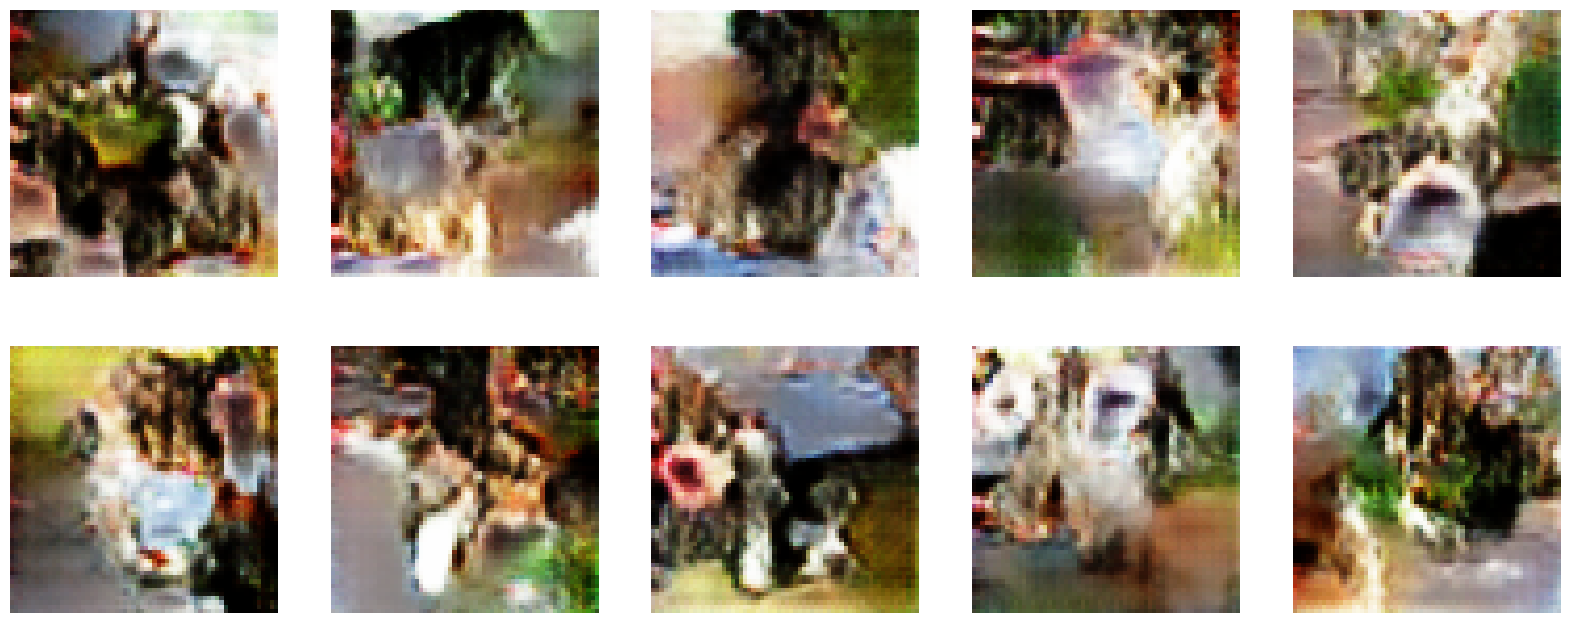

In [ ]:
def generate_and_save_images(generator, num_images=10000, save_path='images'):
    os.makedirs(save_path, exist_ok=True)
    generated_images = []

    for i in tqdm(range(num_images), desc="Generating Images"):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_img = generator(noise).detach().cpu()
        gen_img = np.transpose(gen_img.squeeze(), (1, 2, 0)) * 0.5 + 0.5
        plt.imsave(os.path.join(save_path, f'image_{i}.png'), gen_img.numpy())
        if i < 10:
            generated_images.append(gen_img.numpy())

    # Plot 10 random generated images
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for idx, img in enumerate(generated_images):
        ax = axes[idx // 5, idx % 5]
        ax.imshow(img)
        ax.axis('off')
    plt.show()

    # Create a zip file
    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for root, _, files in os.walk(save_path):
            for file in files:
                zipf.write(os.path.join(root, file))

generate_and_save_images(netG)
